# 行车线及最优速度计算

此notebook代码是从 https://github.com/cdthompson/deepracer-k1999-race-lines 以及https://github.com/dgnzlz/Capstone_AWS_DeepRacer 复制的，做了汉化及格式调整，并将相关的代码及文件拷贝及更新到相应的目录。

In [37]:
!pip install shapely
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

# Ignore deprecation warnings we have no power over
# 忽略我们无法控制的弃用警告，让输出更干净一些
import warnings
warnings.filterwarnings('ignore')

## 加载赛道用于分析
赛道放在tracks目录下，是一个numpy文件

In [38]:
import pandas as pd
import requests

# 从社区下载最新的track文件 https://github.com/aws-deepracer-community/deepracer-race-data/tree/main/raw_data/tracks
!wget https://raw.githubusercontent.com/aws-deepracer-community/deepracer-race-data/main/raw_data/tracks/tracks.csv
tracks_all = pd.read_csv('tracks.csv')
TrackArn_all = tracks_all["TrackArn"]
!rm tracks.csv

track_name_all=[]
for track_arn in TrackArn_all:
    track_name_all.append((track_arn.split('/')[1]))
    
# 列出notebook 本地的track文件
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))

# 找到需要更新的track 文件名
update_tracks = set(track_name_all).difference(set(available_track_names))

if bool(update_tracks):
    fpath = '/home/ec2-user/SageMaker/DeepRacerLabsAndTools/tracks/'

    prefix="https://raw.githubusercontent.com/aws-deepracer-community/deepracer-race-data/main/raw_data/tracks/npy/"
    for track_name in update_tracks:
        fname = track_name + '.npy'
        track_url = prefix + fname
        r = requests.get(track_url)
        with open(fpath+fname, 'wb') as track_file:
            track_file.write(r.content)

track_name_all

['arctic_open',
 'hamption_open',
 'penbay_pro',
 'red_star_pro',
 'thunder_hill_open',
 'H_track',
 'New_York_Eval_Track',
 '2022_april_open',
 'Belille',
 'China_track',
 'FS_June2020',
 'Canada_Training',
 'Virtual_May19_Train_track',
 'reInvent2019_wide_mirrored',
 'caecer_gp',
 'dubai_open',
 'caecer_loop',
 'Oval_track',
 'morgan_open',
 'China_eval_track',
 'New_York_Track',
 'reInvent2019_track',
 'reinvent_base',
 'Albert',
 '2022_summit_speedway',
 'Vegas_track',
 'morgan_pro',
 'arctic_pro',
 'Tokyo_Training_track',
 'reinvent_base_new',
 'Aragon',
 'Spain_track',
 'red_star_open',
 'Mexico_track',
 'London_Loop_Train',
 'LGSWide',
 'canada_race',
 'Mexico_track_eval',
 '2022_march_open',
 'thunder_hill_pro',
 'jyllandsringen_open',
 'Bowtie_track',
 'AWS_track',
 'Straight_track',
 'AmericasGeneratedInclStart',
 'jyllandsringen_pro',
 'dubai_pro',
 'hamption_pro',
 'July_2020',
 'Austin',
 'Canada_Eval',
 'reInvent2019_wide',
 '2022_march_pro',
 'Monaco',
 'penbay_open',
 '

Is loop/ring?  True


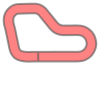

In [93]:
# Replace the name here with the track to analyze
# 替换此变量为想要分析的赛道
TRACK_NAME = 'reinvent_base'

# Load the center, inner, outer waypoints
#加载赛道的中心线和内外路点
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Convert to Shapely objects
# 转换成Shapely对象
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

#### 将numpy格式的赛道waypoint数据转换成txt格式（方便excel 分析）

In [94]:
with open(f'./{TRACK_NAME}.txt', 'w') as f:
#    f.write("[")
    for line in waypoints:
        for ele in line:
            f.write("%s, " % ele)
        if line.all() != waypoints[-1].all():
            f.write(",\n")
#    f.write("]")

In [40]:
# Own code: Reduce width of track
# 减少赛道宽度（目的：使得行车线更加保守，离赛道边缘远一些）

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

# PERC_WIDTH值是指新赛道宽度为初始赛道的百分比，取值0-1之间
def gen_new_border(inner_border, outer_border, PERC_WIDTH=1):
    waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
    waypoints_new = np.asarray(waypoints_new)

    # Convert to Shapely objects
    inner_border_new = waypoints_new[:,2:4]
    outer_border_new = waypoints_new[:,4:6]
    
    return inner_border_new, outer_border_new


#percentage of track width
#设定赛道宽度的百分比，取值0-1之间，取值为0则为中间线
#PERC_WIDTH = 0.8
#waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
#waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
#inner_border_new = waypoints_new[:,2:4]
#outer_border_new = waypoints_new[:,4:6]
#l_inner_border_new = LineString(inner_border_new)
#l_outer_border_new = LineString(outer_border_new)


Is loop/ring?  True


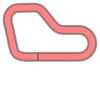

In [41]:
inner_border_new,outer_border_new = gen_new_border(inner_border, outer_border, 0.8)
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((outer_border_new, np.flipud(inner_border_new))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

## 画出赛道的路点图
原始赛道和保守策略的赛道

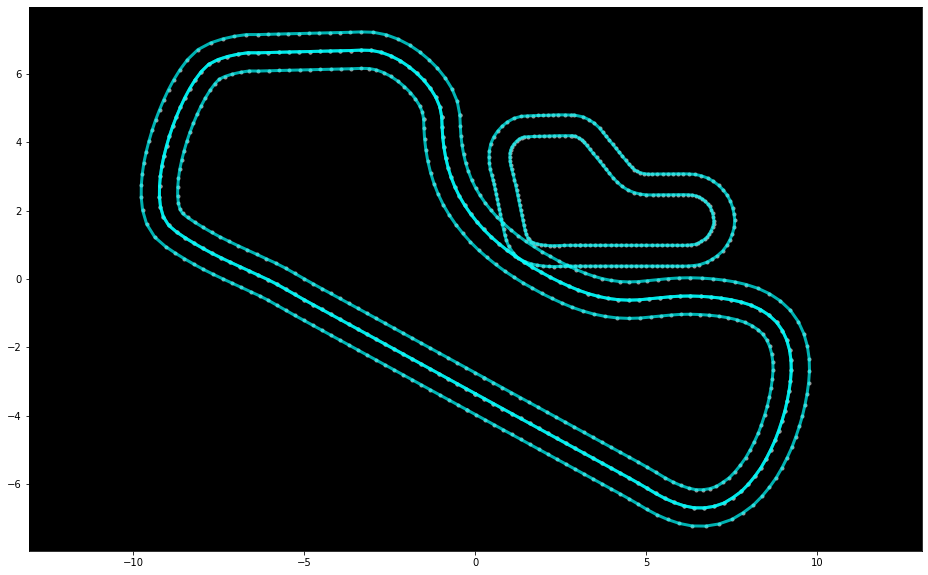

In [86]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

# Also print new border
# 也打印减少赛道宽度后的边界线
print_border(ax, center_line, inner_border_new, outer_border_new)


In [43]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# 门格曲率，通过3个点的圆半径的倒数
def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [44]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
# 更新行车线的迭代次数
XI_ITERATIONS=8 # default 4


def improve_race_line(old_line, inner_border, outer_border, PERC_WIDTH = 1):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    inner_border_new, outer_border_new = gen_new_border(inner_border, outer_border, PERC_WIDTH)
    ls_inner_border = Polygon(inner_border_new)
    ls_outer_border = Polygon(outer_border_new)

    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

## 计算最短行车线

In [77]:
# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
# 迭代时扫描赛道的次数
LINE_ITERATIONS=1500 # default 1000

print(len(center_line))
# start along centerline of track
# 从赛道中心线开始
race_line = copy.deepcopy(center_line[:-1])
for i in range(LINE_ITERATIONS):
    #race_line = improve_race_line(race_line, inner_border_new, outer_border_new)  #计算保守策略下的最优行车线
    race_line = improve_race_line(race_line, inner_border, outer_border, PERC_WIDTH = 1) #计算默认赛道最优行车线
    if i % 20 == 0: print("Iteration %d" % i, end="\r", flush=True)

169


These should be the same:  ((169, 2), (169, 2))
Original centerline length: 50.30
New race line length: 47.42


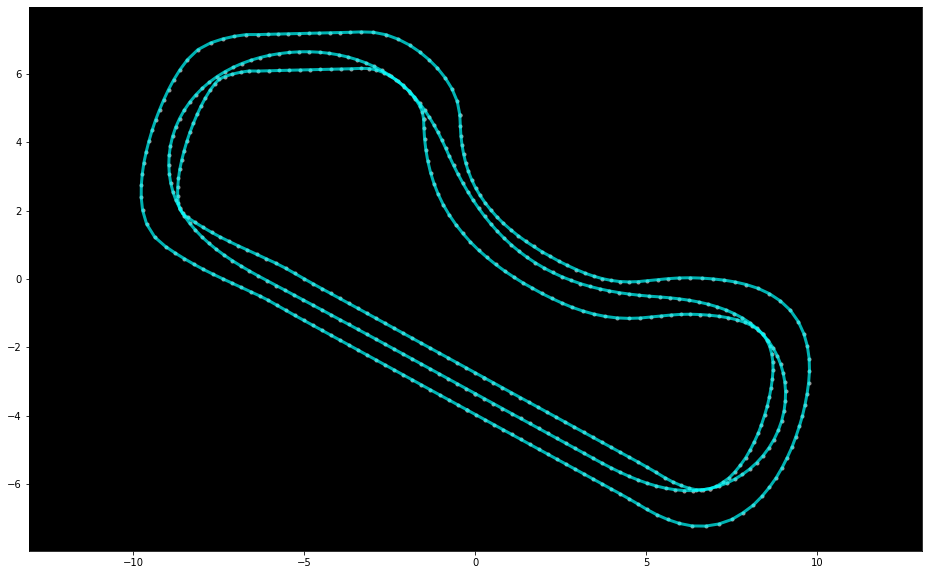

In [78]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
# 复制下第一个点，使得行车线成为闭环
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

## 存储行车线
1. numpy格式，方便加载分析
2. 文本（text)格式，可以直接复制到奖励函数中
3. 存储路径：./racelines/ ， 文件名组成：赛道名称+LINE迭代次数+XI迭代次数+时间戳

In [79]:
from datetime import datetime

now = datetime.now()
prefix = './racelines/%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to ./racelines/2022_april_open-1500-8-2022-04-10-094334.py
Writing numpy binary to ./racelines/2022_april_open-1500-8-2022-04-10-094334.npy


# 计算最佳速度
#### 第 1 部分：从最佳赛车线计算最佳速度
- 第1部分采用最佳赛车线，并为赛车线上的每个点生成最佳速度
- 输入：.py 文件，包含 2D 数组，包含最佳赛车线：2 列 (x,y)
- 输出：具有 2D 数组的 .py 文件：4 列（x、y、速度、预期时间）。 这个数组可以插入到奖励函数中
- 注：赛车线的最后一个点被删除，因为它与第一个点相同

#### 第 2 部分：计算动作空间
- 第2部分采用最佳赛车路线和速度，并使用 K-Means 和高斯噪声注入数据，计算动作空间

In [50]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math

# Ignore deprecation warnings we have no power over
# 忽略我们无法控制的弃用警告，让输出更干净一些
import warnings
warnings.filterwarnings('ignore')

获取之前已经生成的赛道最佳行车线文件，可以根据需要直接写入文件名称

In [80]:
# Path of the optimal racing line (.npy file)
# 获取最佳行车线文件
#fpath = "Spain_racing_line.npy"
#fpath = './racelines/2022_march_open-1500-8-2022-04-02-084321.npy'
fpath = npy_fname

# Change manually (this is only so that output files are named correctly)
# 设定赛道名称
#TRACK_NAME = "2022_april_open"

# 加载最佳行车线
racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
# 转化为list，并删除最后一个点（与初始点相同）
racing_track = racing_track.tolist()[:-1]

## 辅助函数
1. 计算通过3个点的圆弧半径 circle_radius(coords)
2. 往前考虑更多的路点时，获取圆弧半径的3个点的索引
3. 计算最佳速度 optimal_velocity

In [53]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):
    # 计算通过3个点的圆弧半径
    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999
    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
# 返回想要计算圆弧半径范围的3个点的索引
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]

# 计算最佳速度 v=sqrt(Fr/m), F为横向抓地力，m为赛车质量，r为弯道半径，sqrt(F/m)经测试约为1.6-1.75之间
def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    # 计算赛道上每个点（与前后两个点）的半径
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    # 计算最小半径的最大通过速度，F/m因子为1.69
    v_min_r = min(radius)**0.5
    constant_multiple = 1.69
    print(f"Constant multiple for optimal speed: {constant_multiple}")
    #print(f"radius: {radius}")
    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

## 第一部分：计算最佳速度
 
- 修改 LOOK_AHEAD_POINTS 来影响算法提前关注的路点数（此值越大，赛车越早开始减速） 
- 修改 MIN_SPEED 和 MAX_SPEED来适配跑道和模型


In [81]:
LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.33
MAX_SPEED = 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

Constant multiple for optimal speed: 1.69
Constant multiple for optimal speed: 1.69


### 可视化

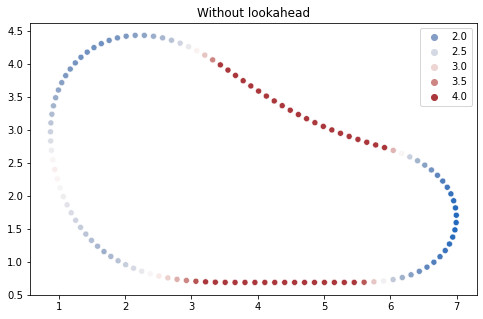

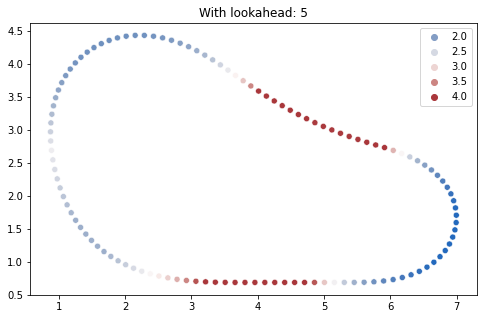

In [55]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]


fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

### 计算行车线每个点之间的距离和最佳时间

In [82]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 13.931901661489503 s


### 将行车线、最佳速度和最佳时间存到一个txt文本文件中，后续可以写入奖励函数

In [83]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

# Write to txt file
with open(f'./racelines/optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")



In [84]:
npy_fname = f'./racelines/optimals_newest_{TRACK_NAME}.npy'
np.save(f'./racelines/optimals_newest_{TRACK_NAME}.npy', racing_track_everything)
print("Writing numpy binary to %s" % npy_fname)


Writing numpy binary to ./racelines/optimals_newest_2022_april_open.npy


## 计算最佳行动空间

In [59]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

In [60]:
min(all_actions['steering'])

-1.706449177938562

Text(0.5, 1.0, 'With lookahead: 5')

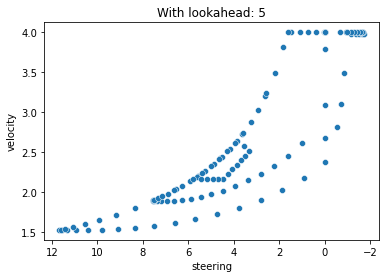

In [61]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

<AxesSubplot:ylabel='Density'>

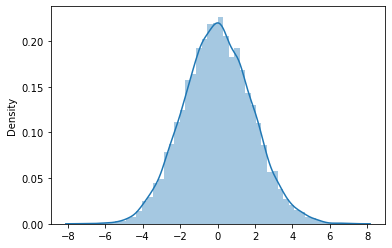

In [62]:
steering_sd = -3 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

<AxesSubplot:ylabel='Density'>

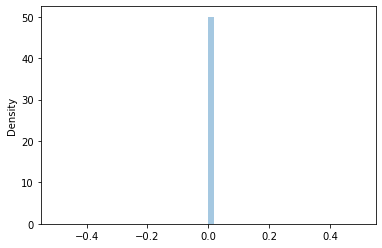

In [63]:
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [64]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -3 / stats.norm.ppf(0.01)

# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)

In [65]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(111847, 2)

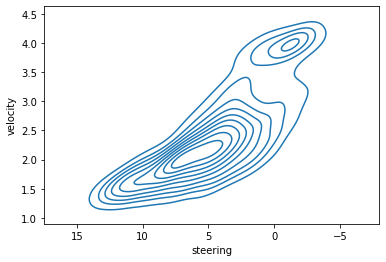

In [66]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time
ax = sns.kdeplot(data=all_actions_norm_less["steering"],data2=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [73]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 19
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[15,-5]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

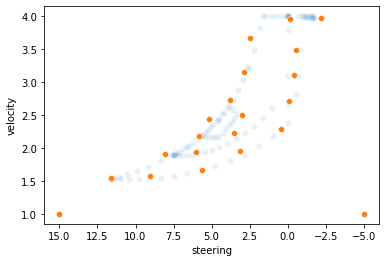

In [74]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

In [75]:
# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()
    
action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json

,steering_angle,speed,index
0,5.6522,1.6631,0
1,-0.5317,3.4912,1
2,2.9918,2.4973,2
3,11.6159,1.5479,3
4,8.0728,1.9133,4
5,-0.4202,3.1049,5
6,5.8349,2.1787,6
7,2.9025,3.1487,7
8,3.1431,1.9506,8
9,-0.1542,3.9529,9
